# Wet dry model intercomparison

The target of this notebook is to compare several algorithms from PyNNCML and pycomlink on open datasets using poligrain.

### Imports

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

# Poligrain for example data
import poligrain as plg

In [ ]:
# include local submodules as packages
for submodule_name in ['PyNNcml',"pycomlink"]:
    sys.path.append(os.path.join(os.getcwd(), submodule_name))
    
from pynncml.cml_methods.apis.xarray_processing.wet_dry_methods import create_wet_dry_std
from pycomlink.processing.pytorch_utils import run_inference
#from pycomlink.processing.tensorflow_utils import run_inference

c:\Users\lukas\Documents\OpenSense\bench-deep-cml\PyNNcml\pynncml\model_zoo\model_common.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\lukas\miniforge3\envs\bench-deep-cml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load OpenMRG Dataset

In [7]:
# OpenMRG Dataset from Poligrain
( ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

# TEMPORARY: select only 3 different CMLs to save memory
ds_cmls = ds_cmls.isel(cml_id = [0, 10, 180])

File already exists at example_data\openmrg_cml_8d.nc
Not downloading!
File already exists at example_data\openmrg_rad_8d.nc
Not downloading!
File already exists at example_data\openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data\openmrg_smhi_gauge_8d.nc
Not downloading!


### A: Run Wet Dry Classification using Std from PyNNCML

In [26]:
# Run STD Wet/Dry classification
wd_std=create_wet_dry_std(threshold=0.2)
ds_cmls_wet_dry=wd_std(ds_cmls)

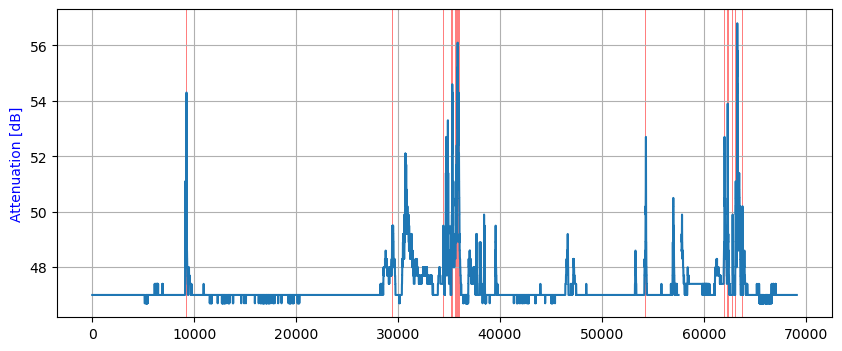

In [27]:
# Plot example CML attenuation and wet/dry classification
ds_wet_dry_selected=ds_cmls_wet_dry.isel(sublink_id=0,cml_id=0)
ds_cml_selected=ds_cmls.isel(sublink_id=0,cml_id=0)
att=np.asarray(ds_cml_selected.tsl)-np.asarray(ds_cml_selected.rsl)
wd=np.asarray(ds_wet_dry_selected.wet_dry_detection).astype(bool)
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(att)
ax1.set_ylabel('Attenuation [dB]', color='b')
# Create a second axes object that shares the same x-axis
#ax2 = ax1.twinx()
#ax2.tick_params('y', colors='r')

#ax2.plot(wd,color="red")
#ax2.set_ylabel('Wet/Dry', color='red')


# Plot wet/dry areas
start = np.roll(wd, -1) & ~wd
end = np.roll(wd, 1) & ~wd
for start_i, end_i in zip(
    start.nonzero()[0],
    end.nonzero()[0],
):
    ax1.axvspan(start_i, end_i, color='r', alpha=0.5, linewidth=0)

#ax1.set_xlim(30000,32000)

plt.grid()
plt.show()

### B: Wet Dry Classification using Pycomlink PyTorch CNN, Polz_2020

In [19]:
# Data adjustments for model input
# Rename dimension to match expected input of model
cmls = ds_cmls.rename_dims(dims_dict={'sublink_id': 'channel_id'})

# Calculate total loss (previous TRSL)
cmls['tl'] = cmls.tsl - cmls.rsl 

# Dataarray shape is expected to be (time, channels, cml_id)
tl = cmls.tl.transpose('time', 'channel_id', 'cml_id')

# Normalisation
tl_normed = tl - tl.median(dim='time')

In [20]:
# CNN inference
# Url adress:
model_URL = "https://github.com/jpolz/cml_wd_pytorch/raw/be2b15fa987838ea1f709dd0180917eebf66271a/data/dummy_model/best_model_jit.pt"
result = run_inference.cnn_wd(model_path_or_url=model_URL,data=tl_normed)

# Create binary wet/dry classification from probabilistic output
cnn_wd_threshold = 0.8
result['cnn_wd'] = (('time','cml_id'), result.predictions.values > cnn_wd_threshold)

Using cached model at C:\Users\lukas\.cml_wd_pytorch\models\model_82cadc59c69484be44b1bd4226e1afe4.pt
✅ Loaded exported model from: C:\Users\lukas\.cml_wd_pytorch\models\model_82cadc59c69484be44b1bd4226e1afe4.pt


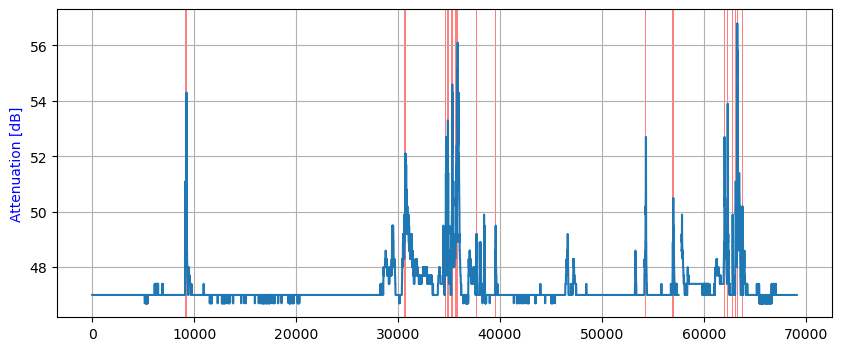

In [24]:
# Plot example CML attenuation and wet/dry classification
att=np.asarray(cmls.isel(channel_id=0,cml_id=0).tl)
wd=np.asarray(result.isel(channel_id=0,cml_id=0).cnn_wd).astype(bool)
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(att)
ax.set_ylabel('Attenuation [dB]', color='b')

# Plot wet/dry areas
start = np.roll(wd, -1) & ~wd
end = np.roll(wd, 1) & ~wd
for start_i, end_i in zip(
    start.nonzero()[0],
    end.nonzero()[0],
):
    ax.axvspan(start_i, end_i, color='r', alpha=0.5, linewidth=0)

#ax.set_xlim(30000,32000)

plt.grid()
plt.show()

In [ ]:
# TODO: unify plot for all methods
# TODO: more detailed plots with probabilities, thresholds, etc.
# TODO: compare results with gauge reference
# TODO: Other intercomparison metrics: ACC, Correction Matrix, MCC, F1-score, ROC-AUC, 

# Common metrics for binary classifier comparison:
# - Accuracy (ACC)
# - Confusion Matrix
# - Precision
# - Recall (Sensitivity, True Positive Rate)
# - Specificity (True Negative Rate)
# - F1-score
# - Matthews Correlation Coefficient (MCC)
# - ROC Curve and Area Under Curve (ROC-AUC)
# - Precision-Recall Curve and AUC
# - Balanced Accuracy
# - Cohen's Kappa

### C: Wet Dry Classification using Pycomlink TensorFlow CNN